# 時系列モデルによる株価予測のデモ

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from pandas_datareader import data as pdr
import mplfinance as mpf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pandas_datareader.data import DataReader
from keras.models import Sequential
from keras.layers import Dense, LSTM
# For time stamps
from datetime import date, datetime, timedelta
from datetime import datetime as dt, timedelta as td
import quantstats as qs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,r2_score

## 株価データの獲得

In [2]:
# yahooサイトからデータをダウンロード
ticker = '7203.T'
end_date = datetime.today()
# 分析に用いるデータ期間を指定する
start_date = end_date - timedelta(days=1200)
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
gs = stock_data.copy()
df = stock_data.copy()

## データの前処理

In [4]:
# Preprocess data
dataset_ex_df = gs.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

## ARIMAモデルによる予測

In [5]:
# Running Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8244.215, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8245.565, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8244.983, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8245.241, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8245.254, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8242.252, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8244.832, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8245.811, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8244.240, Time=0.69 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8246.673, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8242.216, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8244.731, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8244.216, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8246.370, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

In [6]:
# Running ARIMA model forecasting with 80:20 % train/test split
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

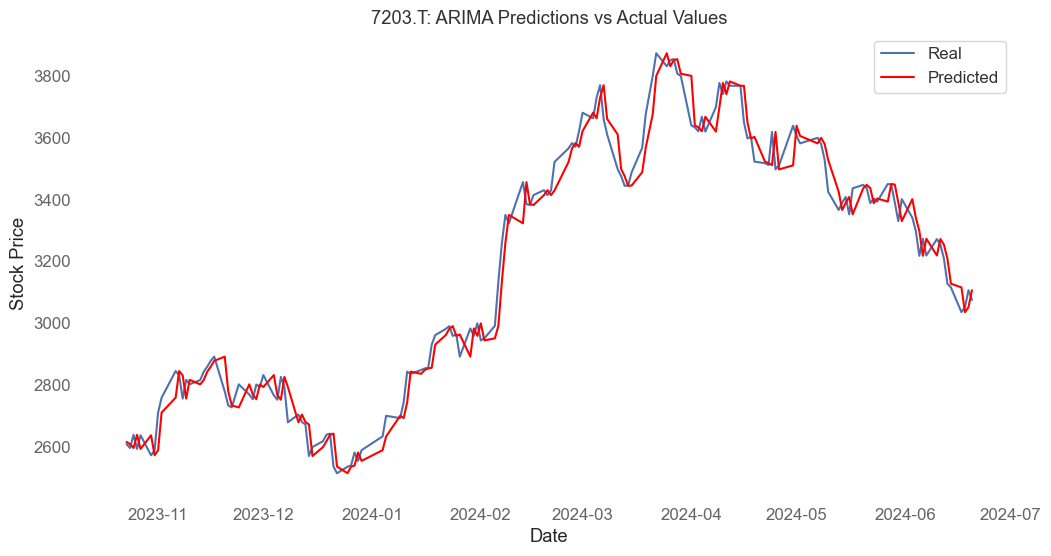

In [7]:
# Plotting ARIMA Predictions vs Actual Values
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title(ticker+' ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

## 高速フーリエ変換による予測

C:\Users\nicjp\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


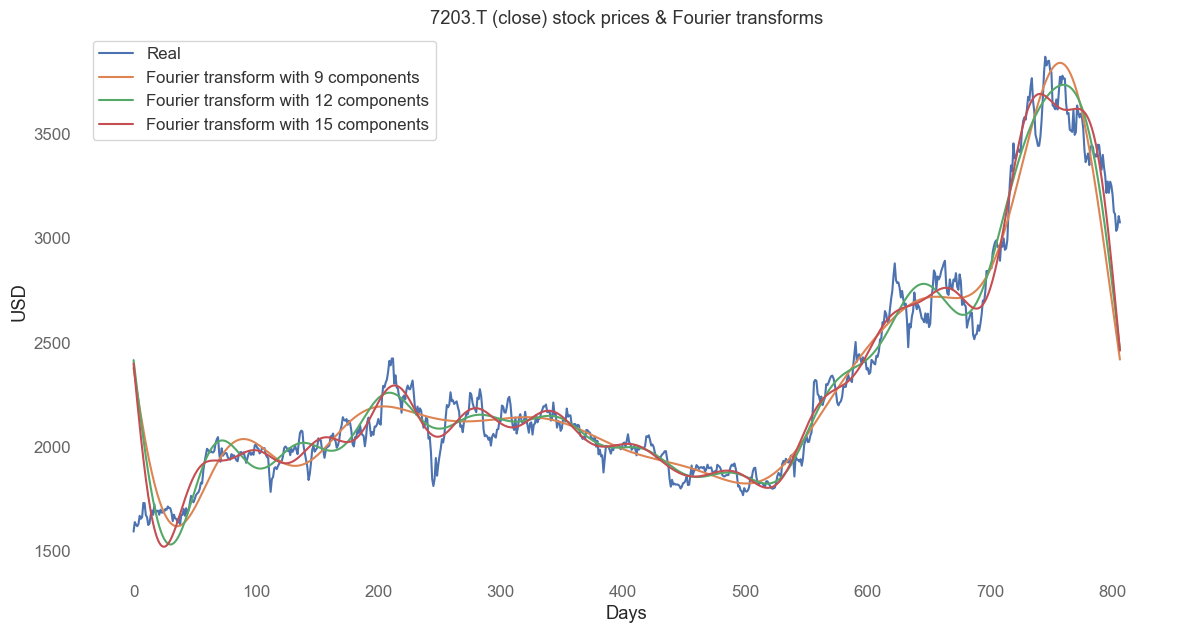

In [8]:
# Calculate the Fourier Transform
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [9, 12, 15]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('USD')
plt.title(ticker+' (close) stock prices & Fourier transforms')
plt.legend()
plt.grid()
plt.show()

## テクニカル指標の計算関数

In [9]:
# Calculate EMA
def ema(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

# Calculate RSI
def rsi(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# Calculate MACD
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line

# Calculate OBV
def obv(close, volume):
    obv = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv

## 単一のデータフレームに統合する

In [10]:
# Add technical indicators to dataset DF
dataset_ex_df['ema_20'] = ema(gs["Close"], 20)
dataset_ex_df['ema_50'] = ema(gs["Close"], 50)
dataset_ex_df['ema_100'] = ema(gs["Close"], 100)

dataset_ex_df['rsi'] = rsi(gs["Close"])
dataset_ex_df['macd'] = macd(gs["Close"])
dataset_ex_df['obv'] = obv(gs["Close"], gs["Volume"])

# Create arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset_ex_df.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset_ex_df[['ema_20', 'ema_50', 'ema_100', 'rsi', 'macd', 'obv', 'Close']]

# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

,ARIMA,Fourier_real,Fourier_imag,ema_20,ema_50,ema_100,rsi,macd,obv,Close
2021-03-26,1671.800049,-4436.251649,20146.590461,1643.779820,1621.034239,1608.469240,61.080186,17.149667,19764000,1671.800049
2021-03-29,1693.000000,-3628.088666,9852.149341,1648.467456,1623.856425,1610.143116,58.243719,18.969679,65902500,1693.000000
2021-03-30,1672.400024,-6102.859071,-4001.766555,1650.746748,1625.760096,1611.375926,56.818190,18.536132,29132000,1672.400024
2021-03-31,1723.199951,-962.138936,13247.786398,1657.647054,1629.581267,1613.590264,63.579933,22.037637,84052000,1723.199951
2021-04-01,1684.599976,2440.707311,16508.741400,1660.213998,1631.738863,1614.996397,56.708495,21.450639,51132500,1684.599976
...,...,...,...,...,...,...,...,...,...,...
2024-06-14,3116.000000,-23724.827644,-70022.785868,3299.250379,3395.959862,3338.223709,25.867052,-87.249954,794424400,3116.000000
2024-06-17,3036.000000,7951.989012,-78325.363163,3274.178914,3381.843789,3332.239081,23.246753,-97.417906,765594600,3036.000000
2024-06-18,3052.000000,-6952.402249,-81102.095177,3253.019017,3368.908738,3326.689792,26.785714,-102.997722,784650600,3052.000000
2024-06-19,3107.000000,5607.498205,-173908.274766,3239.112444,3358.637807,3322.339500,34.578147,-101.808145,802146800,3107.000000


## チャートの描画

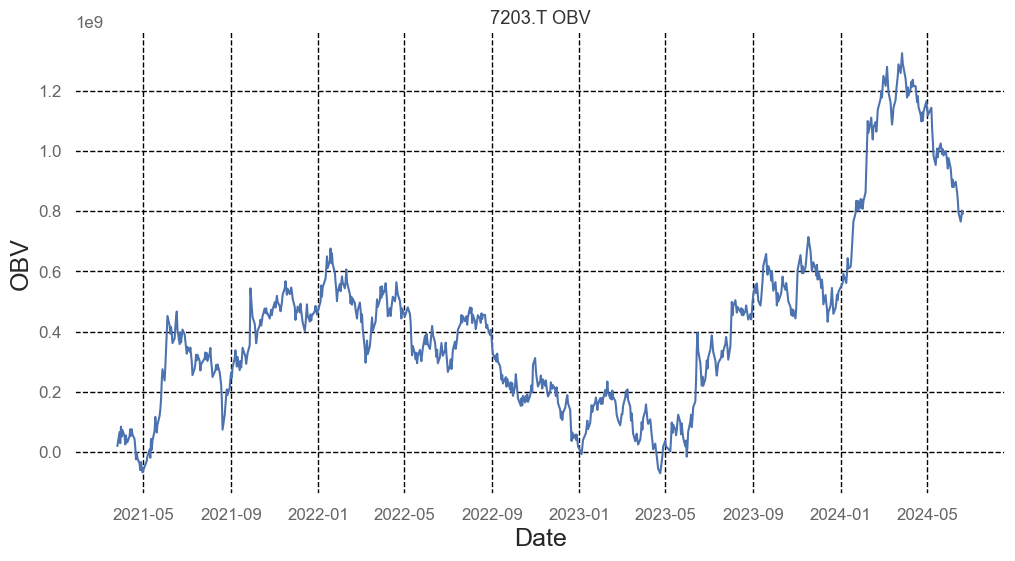

In [11]:
# Plotting JPM OBV
plt.figure(figsize=(12,6))
plt.title(ticker+' OBV')
plt.plot(merged_df['obv'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('OBV', fontsize=18)
plt.grid(color = 'black', linestyle = '--', linewidth = 1)
plt.show()

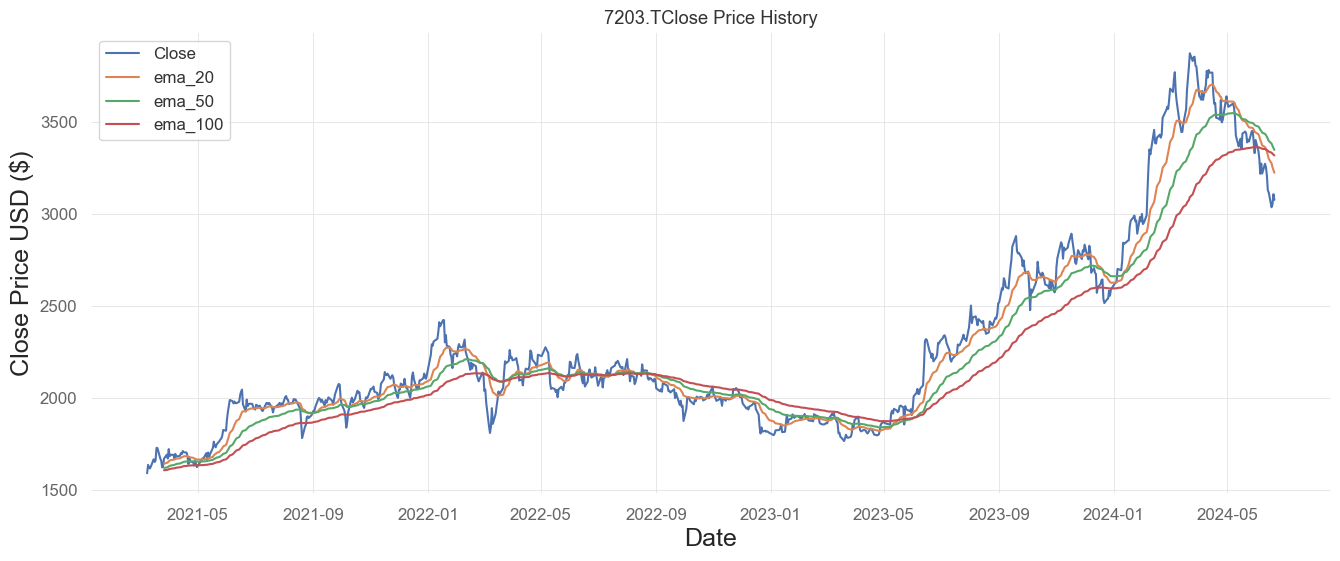

In [12]:
# Plotting JPM EMA
plt.figure(figsize=(16,6))
plt.title(ticker+' Close Price History')
plt.plot(df['Close'])
plt.plot(merged_df['ema_20'])
plt.plot(merged_df['ema_50'])
plt.plot(merged_df['ema_100'])
plt.legend(['Close', 'ema_20','ema_50','ema_100'], loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

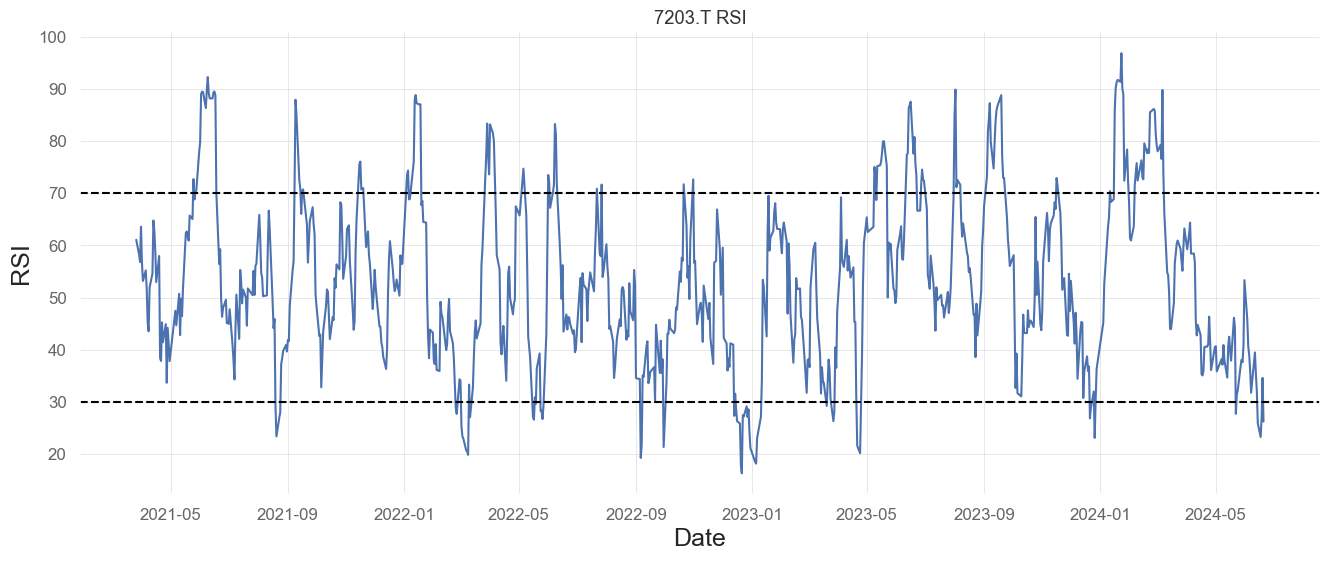

In [13]:
# Plotting RSI
plt.figure(figsize=(16,6))
plt.title(ticker+' RSI')
plt.plot(merged_df['rsi'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('RSI', fontsize=18)
plt.axhline(30, linestyle = '--', linewidth = 1.5, color = 'black')
plt.axhline(70, linestyle = '--', linewidth = 1.5, color = 'black')
plt.show()

### MACDの計算

In [14]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

In [15]:
googl_macd = get_macd(df['Close'], 26, 12, 9)
googl_macd.tail()

,macd,signal,hist
Date,,,
2024-06-14,-87.249954,-72.294959,-14.954995
2024-06-17,-97.417906,-77.319549,-20.098358
2024-06-18,-102.997722,-82.455183,-20.542538
2024-06-19,-101.808145,-86.325776,-15.482369
2024-06-20,-102.188867,-89.498394,-12.690473


In [16]:
def plot_macd(prices, macd, signal, hist):
    plt.figure(figsize=(16,6))
    plt.plot(macd, color = 'black', linewidth = 1.5, label = 'MACD')
    plt.plot(signal, color = 'blue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            plt.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            plt.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'upper left')

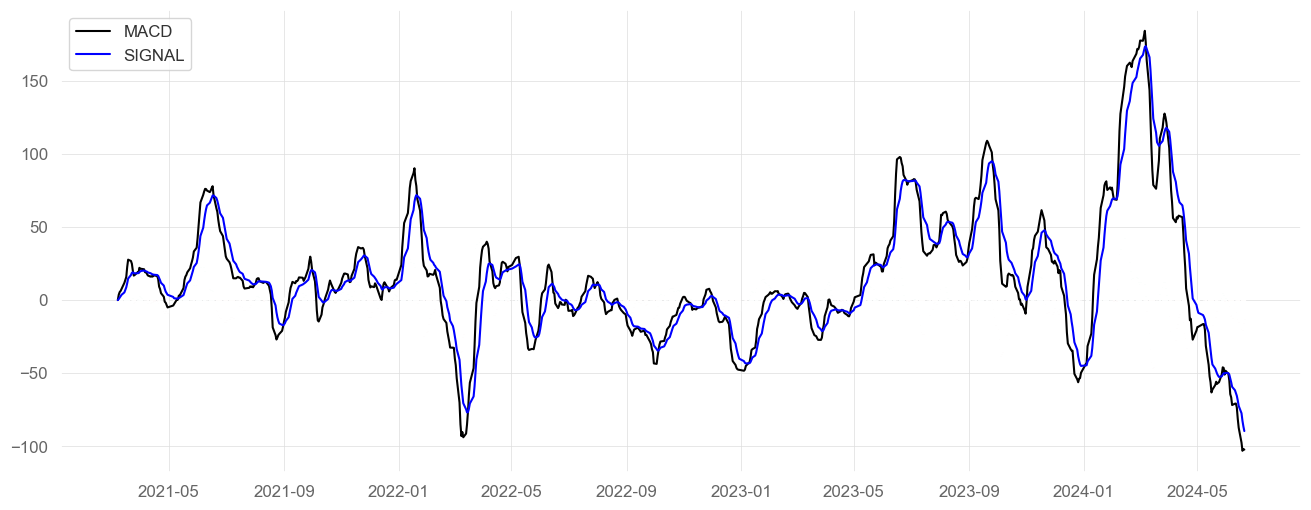

In [17]:
plot_macd(df['Close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

## LSTMによる予測

In [18]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

767

In [19]:
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.        , 0.0200018 , 0.01465042, 0.01140451, 0.01614179,
       0.03324855, 0.02701996, 0.03044128, 0.06044392, 0.05991758,
       0.03517856, 0.0300904 , 0.01394861, 0.01719452, 0.03491539,
       0.04421443, 0.03517856, 0.05746118, 0.04052988, 0.04395125,
       0.0438635 , 0.03552943, 0.04614443, 0.04009125, 0.04009125,
       0.04158262, 0.04789897, 0.04596897, 0.05289942, 0.04991668,
       0.04921487, 0.04009125, 0.02201951, 0.0357049 , 0.02772176,
       0.02666903, 0.01851043, 0.02965177, 0.01456271, 0.03526626,
       0.03535402, 0.04781121, 0.03333626, 0.04930258, 0.03781037,
       0.04535487, 0.06026845, 0.0752698 , 0.06474256, 0.06175982,
       0.06860252, 0.07667341, 0.08035796, 0.08290201, 0.08939383,
       0.10299151, 0.10123697, 0.12825687, 0.14624091, 0.16045269])]
[0.17440130236887508]

[array([0.        , 0.0200018 , 0.01465042, 0.01140451, 0.01614179,
       0.03324855, 0.02701996, 0.03044128, 0.06044392, 0.05991758,
       0.03517856, 0.0300904 , 0.01

### LSTMモデルの構築と実行

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(x_train, y_train, batch_size=1, epochs=32)



Epoch 1/32

707/707 [==============================] - 13s 14ms/step - loss: 0.0030
Epoch 2/32
707/707 [==============================] - 10s 14ms/step - loss: 0.0019
Epoch 3/32
707/707 [==============================] - 10s 14ms/step - loss: 8.6940e-04
Epoch 4/32
707/707 [==============================] - 10s 14ms/step - loss: 8.2015e-04
Epoch 5/32
707/707 [==============================] - 10s 14ms/step - loss: 6.6175e-04
Epoch 6/32
707/707 [==============================] - 10s 14ms/step - loss: 7.4374e-04
Epoch 7/32
707/707 [==============================] - 10s 14ms/step - loss: 0.0012
Epoch 8/32
707/707 [==============================] - 10s 14ms/step - loss: 7.2406e-04
Epoch 9/32
707/707 [==============================] - 10s 14ms/step - loss: 6.5503e-04
Epoch 10/32
707/707 [==============================] - 10s 14ms/step - loss: 6.4946e-04
Epoch 11/32
707/707 [==============================] - 10s 14ms/step - loss: 6.3413e-04
Epoch 12/32
707/707 [=============================

dict_keys(['loss'])


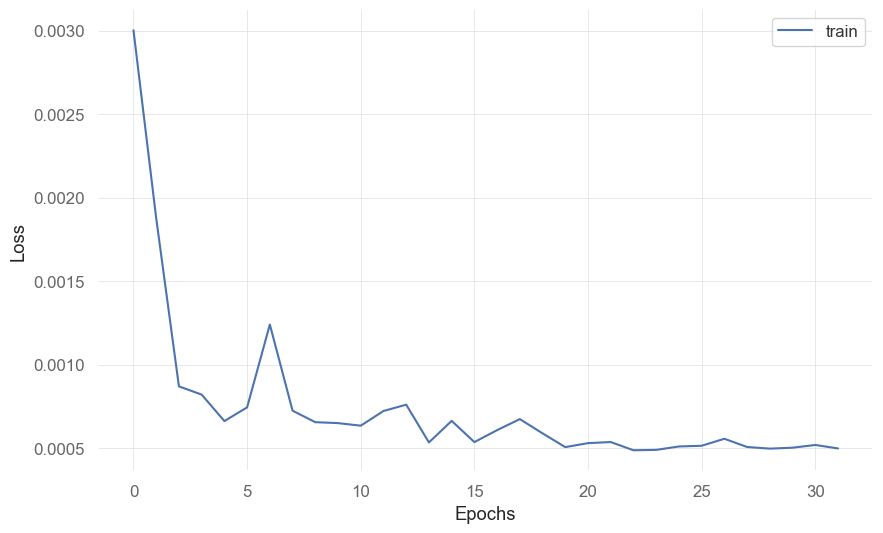

In [21]:
# Plotting the train loss function
print(history.history.keys())
#dict_keys(['loss'])

plt.plot(history.history['loss'], label='train')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### テストデータセットの作成と予測計算

In [22]:
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 9ms/step


73.80305374726137

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### テスト予測誤差の計算

In [24]:
# Calculate test metrics
y_pred=predictions
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

Mean Squared Error (MSE): 5446.89074242115
Mean Absolute Error (MAE): 63.08402099609375
R2 Score: 0.792233538366956
Explained Variance Score: 0.869529890940372
Mean Absolute Percentage Error (MAPE): 1.8838367329227839
Mean Percentage Error (MPE): -1.3661828007562253


C:\Users\nicjp\AppData\Local\Temp\ipykernel_7944\3383132431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


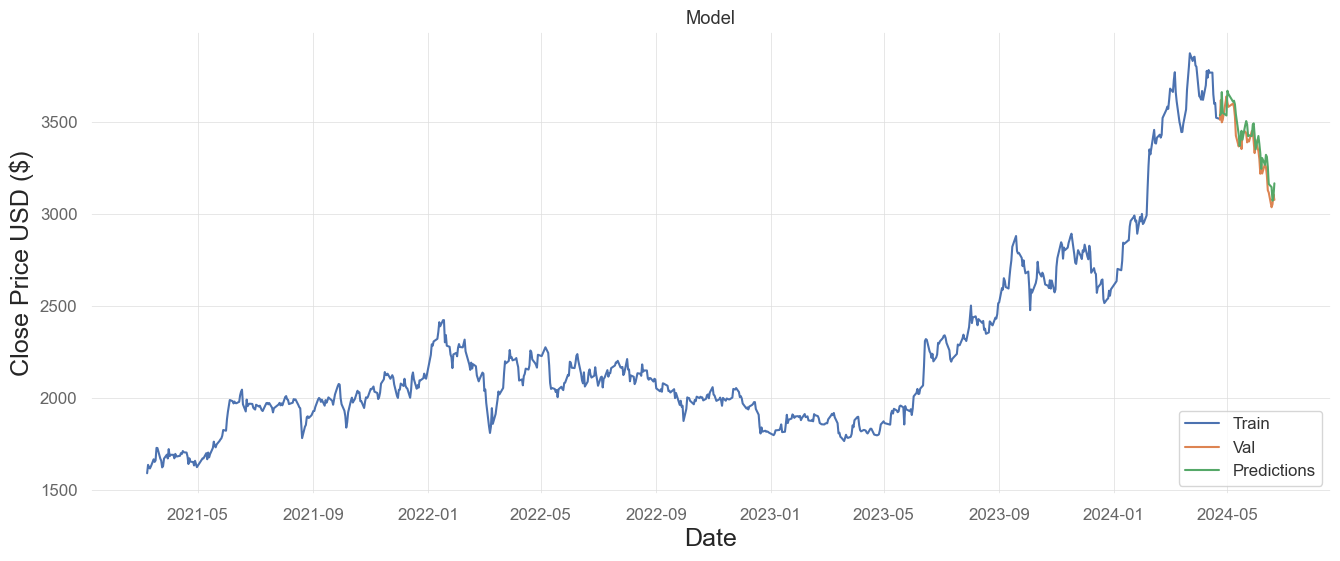

In [25]:
# Plotting train, QC validation and prediction data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()